In [54]:
import itertools
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
from sklearn.metrics import classification_report

In [55]:
train = pd.read_csv("Data/preprocessed/train_preprocessed.csv") 
test = pd.read_csv("Data/preprocessed/test_preprocessed.csv")        
target = pd.read_csv("Data/preprocessed/test_target.csv")  

In [56]:
X_train = train.drop(columns=["AdoptionSpeed", "PetID"])
y_train = train["AdoptionSpeed"]

X_test = test.drop(columns=["PetID"])
y_test = target["AdoptionSpeed"]

#### 1. Baseline: 41 % Accuracy, 0.40 F1 Score
#### 2. Parameter Raster bauen, alle Kombinationen per Grid Search durchlaufen
#### 3. Metriken, inkl. Accuracy, F1, Overfitting Indikatoren und Trainingszeit
#### 4. Analyse mit Heatmaps, etc.

learning rate --- max_depth

Tiefere Bäume benötigen niedrige Lernraten um Overfitting zu vermeiden und stabile Konvergenz zu gewährleisten. Hohe Lernraten mit tiefen Bäumen führen zu instabilem Training.

In [ ]:
learning_rates = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
max_depths = [3, 4, 14, 20]

results = []

In [58]:
n_repeats = 1  # oder 10, je nach Rechenzeit

for lr, md in itertools.product(learning_rates, max_depths):
    scores = []
    for r in range(n_repeats):
        model = xgb.XGBClassifier(
            objective="multi:softprob",
            num_class=5,
            eval_metric="mlogloss",
            use_label_encoder=False,
            random_state=42,  
            learning_rate=lr,
            max_depth=md,
            early_stopping_rounds=50,
            n_estimators =2000
        )
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        scores.append((acc, f1))
        acc_mean = np.mean([s[0] for s in scores])
        f1_mean = np.mean([s[1] for s in scores])
        results.append({"lr": lr, "max_depth": md, "acc": acc_mean, "f1": f1_mean})
    

/Users/basti/miniforge3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/basti/miniforge3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/basti/miniforge3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/basti/miniforge3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_e

In [59]:
df_results = pd.DataFrame(results)
print(df_results)

      lr  max_depth       acc        f1
0   0.01          2  0.360633  0.337582
1   0.01          8  0.406327  0.384328
2   0.01         14  0.434446  0.416244
3   0.01         20  0.417575  0.401317
4   0.02          2  0.360984  0.339612
5   0.02          8  0.416520  0.395561
6   0.02         14  0.434446  0.416952
7   0.02         20  0.433743  0.418460
8   0.05          2  0.376801  0.355547
9   0.05          8  0.417223  0.396052
10  0.05         14  0.436555  0.417937
11  0.05         20  0.432689  0.416843
12  0.10          2  0.376450  0.356533
13  0.10          8  0.413005  0.393097
14  0.10         14  0.427768  0.409303
15  0.10         20  0.422847  0.406982
16  0.20          2  0.382777  0.362065
17  0.20          8  0.415114  0.395603
18  0.20         14  0.427065  0.408533
19  0.20         20  0.420387  0.404158
20  0.50          2  0.384534  0.365326
21  0.50          8  0.402460  0.383912
22  0.50         14  0.415817  0.398384
23  0.50         20  0.418278  0.404398


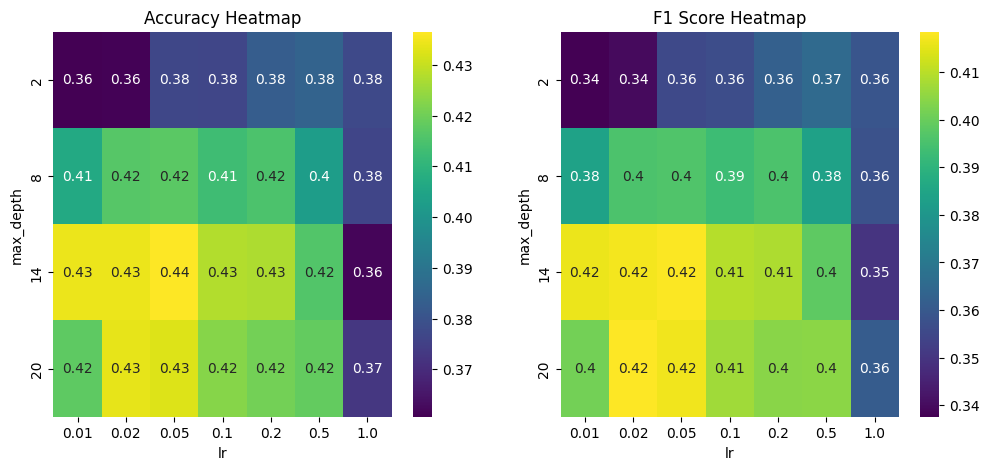

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot_acc = df_results.pivot(index="max_depth", columns="lr", values="acc")
pivot_f1  = df_results.pivot(index="max_depth", columns="lr", values="f1")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(pivot_acc, annot=True, cmap="viridis", ax=ax[0])
ax[0].set_title("Accuracy Heatmap")
sns.heatmap(pivot_f1, annot=True, cmap="viridis", ax=ax[1])
ax[1].set_title("F1 Score Heatmap")
plt.show()


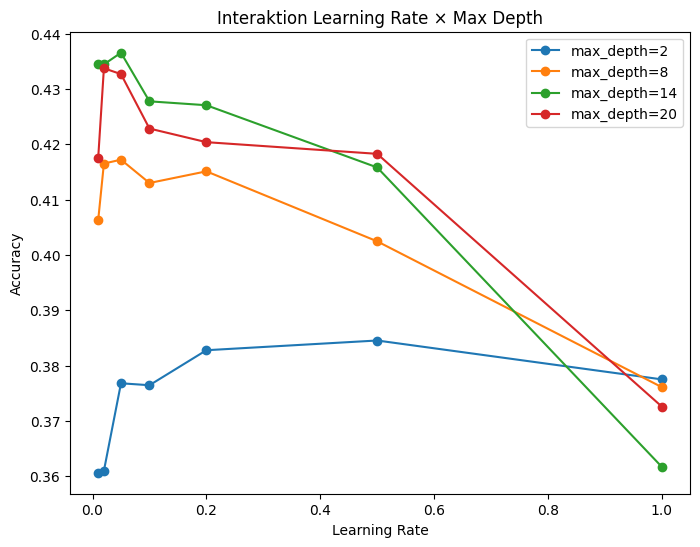

In [61]:
plt.figure(figsize=(8,6))
for md in df_results["max_depth"].unique():
    subset = df_results[df_results["max_depth"] == md]
    plt.plot(subset["lr"], subset["acc"], marker="o", label=f"max_depth={md}")

plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Interaktion Learning Rate × Max Depth")
plt.legend()
plt.show()
